# The first prototype of the sensitivity analysis workflow. 

The workflow is designed to run from the inside of the docker container and assumes a specific folder layout.  

Authors: Tobey Carman and Elchin Jafarov

## Working with the docker 
Assuming that docker was successfully installed, navigate to your local dvmdostem folder:

1. Strat the containers <br/>
`$ docker compose up -d` <br/>
2. Enter to the container <br/>
`$ docker compose exec dvmdostem-run bash` <br/>
3. Start jupyter notebook inside the /work folder <br/>
`$ jupyter notebook --ip 0.0.0.0 --no-browser --allow-root` <br/>
4. Copy the url into your browser. <br/>
5. When done. Shut down container <br/>
`$ docker compose down` <br/>

In [2]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import output_utils as ou
import os
import subprocess

In [3]:
class Sensitivity:
    """Sensitivity analysis class """

    def __init__(self):
        self.PARAM = 'cmax'
        self.PFTNUM = 1 #plant functional type
        self.CMTNUM = 4 #community type
        # row and columns location of the point/site
        self.PXx = 0; 
        self.PXy = 0 
        # the variable corresponds to the path where we will run the analysis
        self.work_dir = '/data/workflows/sensitivity_analysis'
        self.input_cat = '/data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/'
        # the sample distribution range (in this case vcmax in [vcmax_min,vcmax_max])
        self.samples = np.linspace(start=100, stop=700, num=20)

    def setup(self):
        os.chdir('/work/scripts')

        if os.path.exists(self.work_dir):
            os.system('rm -r {}'.format(self.work_dir))

        #copies config files and params directory
        #copy input data files to the D_RUNFOLDER folder
        print('Copy input files into the new_folder')
        %run -i setup_working_directory.py \
        --input-data-path {self.input_cat} {self.work_dir}
        print()
        print('---')
        
        print('Apply the mask')
        %run -i runmask-util.py \
        --reset --yx {self.PXy} {self.PXx} {self.work_dir}/run-mask.nc
        print()
        print('---')
        
        # Outputs: GPP, monthly and pft resolution
        print('Setup output variable temporal resolution')
        %run -i outspec_utils.py \
        {self.work_dir}/config/output_spec.csv --on GPP m p
        print()
        print('---')
        
        #Turn on the CMT output only yearly resolution
        print('Turn on the CMT output only yearly resolution')
        %run -i outspec_utils.py \
        {self.work_dir}/config/output_spec.csv --on CMTNUM y
        print()
        print('---')
        
        # Config, enable eq outputs
        CONFIG_FILE = self.work_dir + '/config/config.js'
        # Read the existing data into memory
        with open(CONFIG_FILE, 'r') as f:
            config = json.load(f)
            
        # Modify it
        config['IO']['output_nc_eq'] = 1

        # Write it back..
        print('CONFIG_FILE:',CONFIG_FILE,'was modified!')
        with open(CONFIG_FILE, 'w') as f:
            json.dump(config, f, indent=2)
            
    def update_param(self,new_value):
        # reading dvmdostem param file and puts it in the json format
        data = !param_util.py --dump-block-to-json {self.work_dir}/default_parameters/cmt_calparbgc.txt {self.CMTNUM}
        jdata = json.loads(data[0])

        pft = 'pft{}'.format(self.PFTNUM)
        jdata[pft][self.PARAM] = new_value

        with open("tmp_json.json", 'w') as f:
            json.dump(jdata, f)

        new_data = !param_util.py --fmt-block-from-json tmp_json.json {self.work_dir}/default_parameters/cmt_calparbgc.txt

        with open('{:}/parameters/cmt_calparbgc.txt'.format(self.work_dir), 'w') as f:
            # make sure to add newlines!
            f.write('\n'.join(new_data))
    
    def collect_outputs(self):
        # Get the model output
        ds = nc.Dataset('{}/output/GPP_monthly_eq.nc'.format(self.work_dir))
        gpp = ds.variables['GPP'][:]
        yr_gpp = ou.sum_monthly_flux_to_yearly(gpp)
        # grab the last time step
        output_data = yr_gpp[-1:,self.PFTNUM,self.PXy,self.PXx]

        # Get the parameter value for the run
        paramdata = !param_util.py --dump-block-to-json {self.work_dir}/parameters/cmt_calparbgc.txt {self.CMTNUM}
        jparamdata = json.loads(paramdata[0])
        pft = 'pft{}'.format(self.PFTNUM)
        run_param_value = jparamdata[pft][self.PARAM]

        #need to modify if we want to save timeseries output
        with open('{}/sensitivity.csv'.format(self.work_dir), 'a') as f:
            f.write('{:},{:}\n'.format(run_param_value, output_data[0]))

    def run_model(self):
        command_line = '/work/dvmdostem'
        #options = '-p 50 -e 200 -s 0 -t 0 -n 0 -l err --force-cmt {}'.format(CMTNUM)
        options = '-p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt {}'.format(self.CMTNUM)
        command_line = command_line + ' ' + options
        print (command_line)
        status=subprocess.call(command_line, shell=True)


In [4]:
x=Sensitivity()
x.setup()

# Backup default params
!cp -r {x.work_dir}/parameters {x.work_dir}/default_parameters
# Make a file for storing our sensitivity data
# and put the header in the file.
with open('{}/sensitivity.csv'.format(x.work_dir), 'w') as f:
    f.write('{:},{:}\n'.format('pvalue','output'))

os.chdir(x.work_dir)
x.run_model()
x.collect_outputs()

for i in x.samples:
    print("adjust_param({:}) --> run_model() --> collect_outputs()".format(i))
    x.update_param(i)
    x.run_model()
    x.collect_outputs()

Copy input files into the new_folder
Namespace(copy_inputs=False, input_data_path='/data/input-catalog/cru-ts40_ar5_rcp85_ncar-ccsm4_CALM_Toolik_LTER_10x10/', new_directory='/data/workflows/sensitivity_analysis', no_cal_targets=False)

---
Apply the mask
Setting all pixels in runmask to '0' (OFF).
Turning pixel(y,x) (0,0) to '1', (ON).

---
Setup output variable temporal resolution
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
                 GPP            g/m2/time            y            m      invalid            p                   invalid       double     GPP

---
Turn on the CMT output only yearly resolution
                Name                Units       Yearly      Monthly        Daily          PFT Compartments       Layers    Data Type     Description
              CMTNUM                    m            y      invalid      invalid      invalid      invalid      invalid      

[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.8


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(100.0) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (8, 4)
[fatal] [] Skipping cell (8, 5)
[fatal] [] Skipping cell (8, 6)
[fatal] [] Skipping cell (8, 7)
[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(131.57894736842104) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(163.1578947368421) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(194.73684210526315) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 10


[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(226.31578947368422) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 10


[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(257.89473684210526) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 10
adjust_param(289.4736842105263) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9
adjust_param(321.0526315789474) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 10
adjust_param(352.63157894736844) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 8


[fatal] [] Skipping cell (8, 1)
[fatal] [] Skipping cell (8, 2)
[fatal] [] Skipping cell (8, 3)
[fatal] [] Skipping cell (8, 4)
[fatal] [] Skipping cell (8, 5)
[fatal] [] Skipping cell (8, 6)
[fatal] [] Skipping cell (8, 7)
[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(384.2105263157895) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (7, 8)
[fatal] [] Skipping cell (7, 9)
[fatal] [] Skipping cell (8, 0)
[fatal] [] Skipping cell (8, 1)
[fatal] [] Skipping cell (8, 2)
[fatal] [] Skipping cell (8, 3)
[fatal] [] Skipping cell (8, 4)
[fatal] [] Skipping cell (8, 5)
[fatal] [] Skipping cell (8, 6)
[fatal] [] Skipping cell (8, 7)
[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(415.7894736842105) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9
adjust_param(447.36842105263156) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(478.9473684210526) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(510.52631578947364) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(542.1052631578948) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (7, 9)
[fatal] [] Skipping cell (8, 0)
[fatal] [] Skipping cell (8, 1)
[fatal] [] Skipping cell (8, 2)
[fatal] [] Skipping cell (8, 3)
[fatal] [] Skipping cell (8, 4)
[fatal] [] Skipping cell (8, 5)
[fatal] [] Skipping cell (8, 6)
[fatal] [] Skipping cell (8, 7)
[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(573.6842105263158) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 10


[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(605.2631578947369) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 8


[fatal] [] Skipping cell (8, 0)
[fatal] [] Skipping cell (8, 1)
[fatal] [] Skipping cell (8, 2)
[fatal] [] Skipping cell (8, 3)
[fatal] [] Skipping cell (8, 4)
[fatal] [] Skipping cell (8, 5)
[fatal] [] Skipping cell (8, 6)
[fatal] [] Skipping cell (8, 7)
[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(636.8421052631579) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 8
adjust_param(668.421052631579) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 8


[fatal] [] Skipping cell (7, 9)
[fatal] [] Skipping cell (8, 0)
[fatal] [] Skipping cell (8, 1)
[fatal] [] Skipping cell (8, 2)
[fatal] [] Skipping cell (8, 3)
[fatal] [] Skipping cell (8, 4)
[fatal] [] Skipping cell (8, 5)
[fatal] [] Skipping cell (8, 6)
[fatal] [] Skipping cell (8, 7)
[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


adjust_param(700.0) --> run_model() --> collect_outputs()
/work/dvmdostem -p 5 -e 5 -s 5 -t 5 -n 5 -l err --force-cmt 4
Setting up logging...


[err] [PRE-RUN->Y] y: 0 x: 0 Year: 0
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 1
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 2
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 3
[err] [PRE-RUN->Y] y: 0 x: 0 Year: 4
[fatal] [EQ] Equilibrium Initial Year Count: 5
[fatal] [EQ] Running Equilibrium, 5 years.
[err] [EQ->Y] y: 0 x: 0 Year: 0
[err] [EQ->Y] y: 0 x: 0 Year: 1
[err] [EQ->Y] y: 0 x: 0 Year: 2
[err] [EQ->Y] y: 0 x: 0 Year: 3
[err] [EQ->Y] y: 0 x: 0 Year: 4
[fatal] [SP] Running Spinup, 5 years.
[err] [SP->Y] y: 0 x: 0 Year: 0
[err] [SP->Y] y: 0 x: 0 Year: 1
[err] [SP->Y] y: 0 x: 0 Year: 2
[err] [SP->Y] y: 0 x: 0 Year: 3
[err] [SP->Y] y: 0 x: 0 Year: 4
[fatal] [TR] Running Transient, 5 years
[err] [TR] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [TR->Y] y: 0 x: 0 Year: 0
[err] [TR->Y] y: 0 x: 0 Year: 1
[err] [TR->Y] y: 0 x: 0 Year: 2
[err] [TR->Y] y: 0 x: 0 Year: 3
[err] [TR->Y] y: 0 x: 0 Year: 4
[fatal] [SC] Running Scenario, 5 years.
[err] [SC] MAKE SURE YOUR FIRE INPUTS ARE SETUP CORRECTLY!
[err] [SC

cell 0, 0 complete.7


[fatal] [] Skipping cell (0, 1)
[fatal] [] Skipping cell (0, 2)
[fatal] [] Skipping cell (0, 3)
[fatal] [] Skipping cell (0, 4)
[fatal] [] Skipping cell (0, 5)
[fatal] [] Skipping cell (0, 6)
[fatal] [] Skipping cell (0, 7)
[fatal] [] Skipping cell (0, 8)
[fatal] [] Skipping cell (0, 9)
[fatal] [] Skipping cell (1, 0)
[fatal] [] Skipping cell (1, 1)
[fatal] [] Skipping cell (1, 2)
[fatal] [] Skipping cell (1, 3)
[fatal] [] Skipping cell (1, 4)
[fatal] [] Skipping cell (1, 5)
[fatal] [] Skipping cell (1, 6)
[fatal] [] Skipping cell (1, 7)
[fatal] [] Skipping cell (1, 8)
[fatal] [] Skipping cell (1, 9)
[fatal] [] Skipping cell (2, 0)
[fatal] [] Skipping cell (2, 1)
[fatal] [] Skipping cell (2, 2)
[fatal] [] Skipping cell (2, 3)
[fatal] [] Skipping cell (2, 4)
[fatal] [] Skipping cell (2, 5)
[fatal] [] Skipping cell (2, 6)
[fatal] [] Skipping cell (2, 7)
[fatal] [] Skipping cell (2, 8)
[fatal] [] Skipping cell (2, 9)
[fatal] [] Skipping cell (3, 0)
[fatal] [] Skipping cell (3, 1)
[fatal] 

Total Seconds: 9


[fatal] [] Skipping cell (7, 9)
[fatal] [] Skipping cell (8, 0)
[fatal] [] Skipping cell (8, 1)
[fatal] [] Skipping cell (8, 2)
[fatal] [] Skipping cell (8, 3)
[fatal] [] Skipping cell (8, 4)
[fatal] [] Skipping cell (8, 5)
[fatal] [] Skipping cell (8, 6)
[fatal] [] Skipping cell (8, 7)
[fatal] [] Skipping cell (8, 8)
[fatal] [] Skipping cell (8, 9)
[fatal] [] Skipping cell (9, 0)
[fatal] [] Skipping cell (9, 1)
[fatal] [] Skipping cell (9, 2)
[fatal] [] Skipping cell (9, 3)
[fatal] [] Skipping cell (9, 4)
[fatal] [] Skipping cell (9, 5)
[fatal] [] Skipping cell (9, 6)
[fatal] [] Skipping cell (9, 7)
[fatal] [] Skipping cell (9, 8)
[fatal] [] Skipping cell (9, 9)


In [5]:
df = pd.read_csv('{:}/sensitivity.csv'.format(x.work_dir))
df.head(4)

,pvalue,output
0,340.000000,164.255175
1,100.000000,43.289263
2,131.578947,58.895300
3,163.157895,73.859708


<AxesSubplot:>

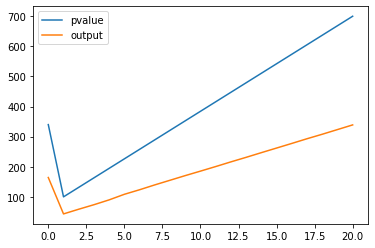

In [6]:
df.plot()

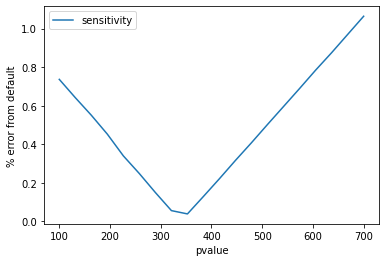

In [7]:
sens_df = pd.DataFrame(dict(pvalue=df.pvalue[1:], sensitivity=abs(df.output[0] - df.output[1:])/abs(df.output[0])))
axes = sens_df.plot('pvalue', 'sensitivity', kind='line', ylabel='% error from default')